### Importing libraries

In [1]:
import pandas as pd
import datetime
from datetime import timedelta
import geopy.distance
import numpy as np 
import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter
import nltk
from nltk.tokenize import word_tokenize 
from collections import Counter
from nltk.corpus import stopwords

### Importing the data

In [2]:
df = pd.read_csv("/Users/luismiguel/Desktop/McGill MMA/Enterprise Analytics/accidents.csv")

### Preprocessing of the data

In [3]:
df = df.drop("Unnamed: 0",axis=1)
start = df["Start_Time"].tolist()
end = df["End_Time"].tolist()
years = []
months =[]
days = []
hours =[]
ends = []
##Getting individual tokens to get the hour, month and  year
for time in start:
    years.append(time.split(" ")[0].split("-")[0])
    months.append(time.split(" ")[0].split("-")[1])
    days.append(time.split(" ")[0].split("-")[2])
    hours.append(time.split(" ")[1].split(":")[0])

### Calculating the duration of the accident

In [4]:
datetimeFormat = '%Y-%m-%d %H:%M:%S'
for begin,finish in zip(start,end):
    ends.append((datetime.datetime.strptime(finish, datetimeFormat) - datetime.datetime.strptime(begin, datetimeFormat)).seconds)

df["Start_Year"] = years
df["Start_Month"] = months
df["Start_Day"] = days
df["Start_Hour"] = hours
df["Accident_Duration"] = ends
df = df.drop("Start_Time",axis=1)
df = df.drop("End_Time",axis=1)

### Calculating the distance of the accident

In [5]:
df['End_Lng'] = df['End_Lng'].fillna(0)
df['End_Lat'] = df['End_Lat'].fillna(0)
start_lat = df["Start_Lat"].tolist()
start_long = df["Start_Lng"].tolist()
end_long = df["End_Lng"].tolist()
end_lat = df["End_Lat"].tolist()
distance = []
i = 0
for i in range(0,500000):
    if end_long[i] == 0:
        end_long[i] = start_long[i]
    if end_lat[i] == 0:
        end_lat[i] = start_lat[i]
    coord1 = (float(start_lat[i]),float(start_long[i]))
    coord2 =  (float(end_lat[i]),float(end_long[i]))
    distance.append(geopy.distance.vincenty(coord1, coord2).mi)

df["Distance(mi)"] = distance

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  app.launch_new_instance()


### Replacing na's with the median

In [6]:
df['Temperature(F)'] = df['Temperature(F)'].fillna(df['Temperature(F)'].median())
df['Wind_Chill(F)'] = df['Wind_Chill(F)'].fillna(df['Wind_Chill(F)'].median())
df['Humidity(%)'] = df['Humidity(%)'].fillna(df['Humidity(%)'].median())
df['Pressure(in)'] = df['Pressure(in)'].fillna(df['Pressure(in)'].median())
df['Visibility(mi)'] = df['Visibility(mi)'].fillna(df['Visibility(mi)'].median())
df['Wind_Speed(mph)'] = df['Wind_Speed(mph)'].fillna(df['Wind_Speed(mph)'].median())
df['Precipitation(in)'] = df['Precipitation(in)'].fillna(df['Precipitation(in)'].median())
df = df.dropna()

# Data Visualization

### Correlation matrix for numerical values

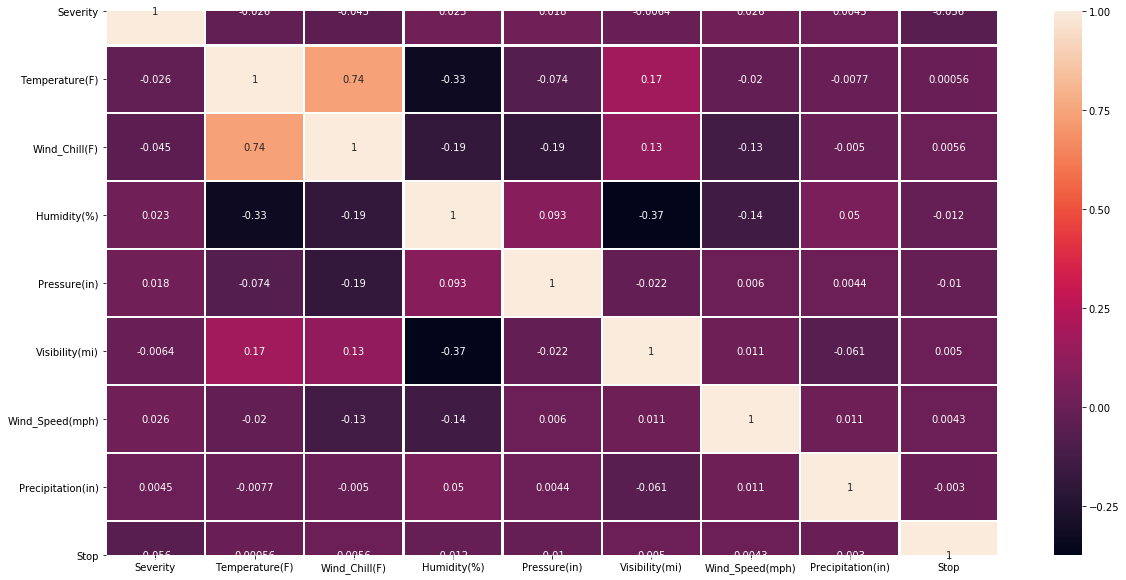

In [45]:
import seaborn as sea
import matplotlib.pyplot as plt
to_correlate = df.loc[:, ['Severity', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)','Start_Year','Stop']]
corrMatrix = to_correlate.corr()
fig, ax = plt.subplots(figsize=(20,10))
sea.heatmap(corrMatrix, annot=True, linewidths=1.5, ax=ax)

### Accidents and States

Text(0, 0.5, '')

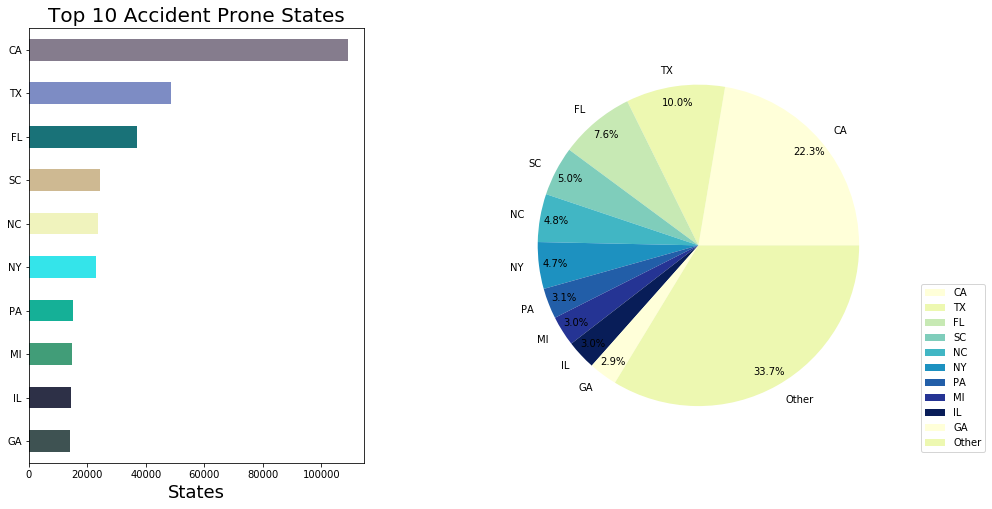

In [95]:
fig,ax=plt.subplots(1,2,figsize=(15,8))
clr = ("#3E5252", "#2D3047", "#419D78", "#15B097", "#34E4EA",'#F0F3BD','#CEB992','#197278','#7D8CC4','#857C8D')
df.State.value_counts().sort_values(ascending=False)[:10].sort_values().plot(kind='barh',color=clr,ax=ax[0])
ax[0].set_title("Top 10 Accident Prone States",size=20)
ax[0].set_xlabel('States',size=18)
count=df['State'].value_counts()
groups=list(df['State'].value_counts().index)[:10]
counts=list(count[:10])
counts.append(count.agg(sum)-count[:10].agg('sum'))
groups.append('Other')
type_dict=pd.DataFrame({"group":groups,"counts":counts})
clr1=("#ffffd9","#edf8b1","#c7e9b4","#7fcdbb","#41b6c4","#1d91c0","#225ea8","#253494","#081d58")
qx = type_dict.plot(kind='pie', y='counts', labels=groups,colors=clr1,autopct='%1.1f%%', pctdistance=0.9, radius=1.2,ax=ax[1])
plt.legend(loc=0, bbox_to_anchor=(1.15,0.4)) 
plt.subplots_adjust(wspace =0.5, hspace =0)
plt.ioff()
plt.ylabel('')


### Accidents and weather

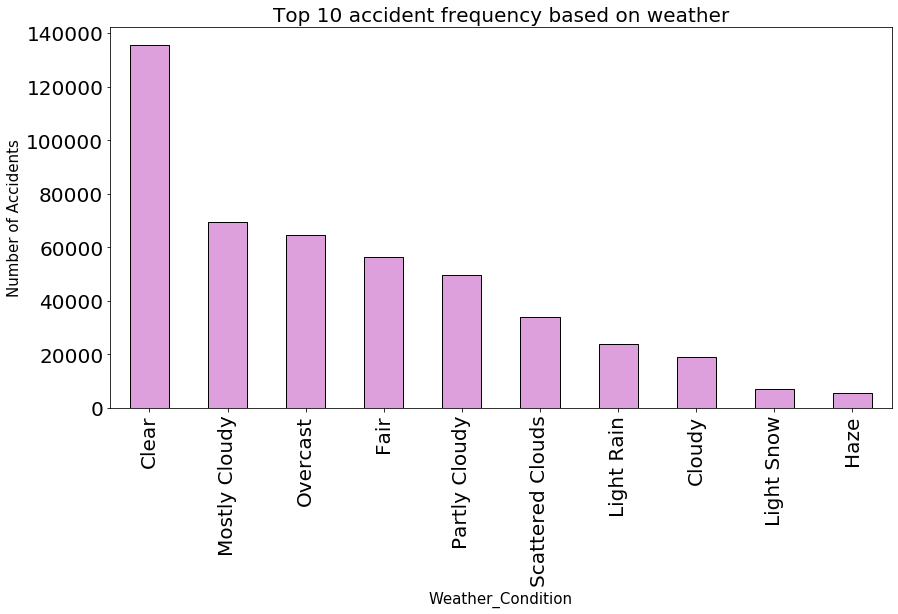

In [76]:
fig, ax=plt.subplots(figsize=(14,7))
df['Weather_Condition'].value_counts().sort_values(ascending=False).head(10).plot.bar(width=0.5,edgecolor='k',align='center',color ="plum")
plt.xlabel('Weather_Condition',fontsize=15)
plt.ylabel('Number of Accidents',fontsize=15)
ax.tick_params(labelsize=20)
plt.title('Top 10 accident frequency based on weather',fontsize=20)
plt.ioff()

### Accidents per Year

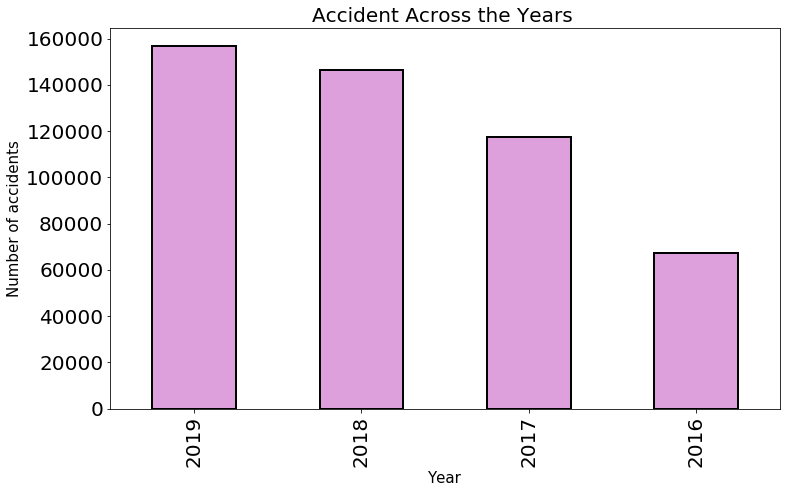

In [77]:
fig, ax=plt.subplots(figsize=(12,7))
df['Start_Year'].value_counts(ascending=False).plot.bar(width=0.5,edgecolor='k',align='center',linewidth=2,color ="plum")
plt.xlabel('Year',fontsize=15)
plt.ylabel('Number of accidents',fontsize=15)
ax.tick_params(labelsize=20)
plt.title('Accident Across the Years ',fontsize=20)
plt.ioff()

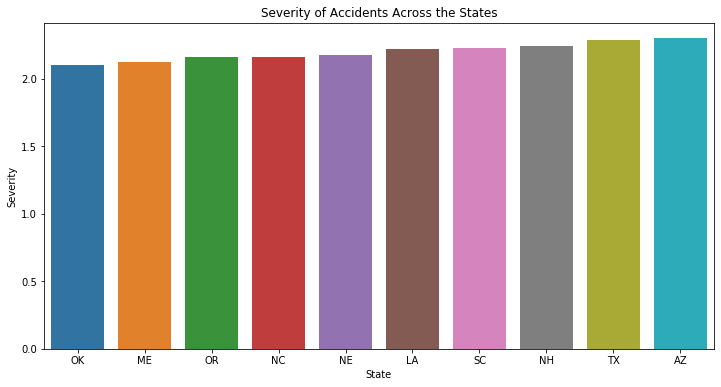

In [100]:
to_plot = df.groupby('State').agg({'Severity': 'mean'}).sort_values('Severity').reset_index().head(10)
plt.figure(figsize=(12,6))
sea.barplot(y="Severity", x="State", data=to_plot)
plt.title("Severity of Accidents Across the States")
plt.ioff()

## Text Analytics

In [7]:
df['Description'] = df['Description'].str.lower()
df['Description']  = df['Description'].str.replace(r'[^a-zA-Z ]\s?',r' ',regex=True)
df['Description'] = df['Description'].str.replace(r'  ',r' ',regex=True)
##Lemetizing the column
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
df['Description'] = df.Description.apply(lemmatize_text)
###################################################Removng stop words
df['Description'] = df['Description'].apply(lambda x: [item for item in x if item not in stop_words])
##Joining the lists back togther
df['Description'] = df['Description'].map(lambda x: ' '.join(x))

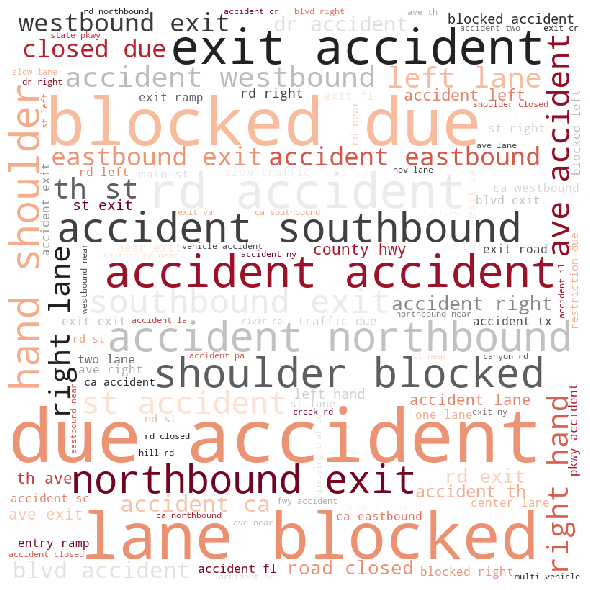

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
lyrics = df["Description"].tolist()
words_lyrics = (" ".join(lyrics)).split(" ")
lyrics_cloud =  " ".join(words_lyrics)
wc = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10,colormap="RdGy").generate(lyrics_cloud)                         
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

## Causal Inference

In [22]:
df1 = df.sample(n=10000)

In [23]:
model=CausalModel(
        data = df1,
        treatment=["No_Exit"],
        outcome="Severity",
        common_causes = ['Precipitation(in)','Stop','Temperature(F)','Traffic_Signal'])

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['No_Exit'] on outcome ['Severity']


In [24]:
model2=CausalModel(
        data = df1,
        treatment=["Visibility(mi)"],
        outcome="Severity",
        common_causes = ['Precipitation(in)','Stop','Temperature(F)','Traffic_Signal','No_Exit'])

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Visibility(mi)'] on outcome ['Severity']


In [25]:
model3=CausalModel(
        data = df1,
        treatment=['Traffic_Signal'],
        outcome="Severity",
        common_causes = ['Precipitation(in)','Stop','Temperature(F)',"Visibility(mi)",'No_Exit'])

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Traffic_Signal'] on outcome ['Severity']


In [26]:
model4=CausalModel(
        data = df1,
        treatment=['Crossing'],
        outcome="Severity",
        common_causes = ['Precipitation(in)','Stop','Temperature(F)',"Visibility(mi)",'No_Exit'])

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Crossing'] on outcome ['Severity']


In [27]:
model5=CausalModel(
        data = df1,
        treatment=['Precipitation(in)'],
        outcome="Severity",
        common_causes = ['Stop','Temperature(F)','Crossing',"Visibility(mi)",'No_Exit'])

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Precipitation(in)'] on outcome ['Severity']


In [28]:
model6=CausalModel(
        data = df1,
        treatment=['Wind_Speed(mph)'],
        outcome="Severity",
        common_causes = ['Precipitation(in)','Crossing','Stop','Temperature(F)','No_Exit'])

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Wind_Speed(mph)'] on outcome ['Severity']


INFO:dowhy.causal_graph:Using Matplotlib for plotting
/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


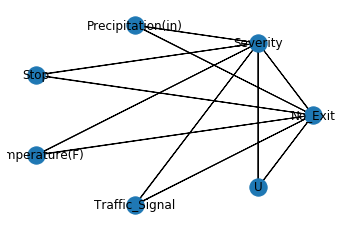

In [29]:
model.view_model()

### Identify the effect

In [30]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Temperature(F)', 'Precipitation(in)', 'U', 'Stop', 'Traffic_Signal']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


In [31]:
identified_estimand2 = model2.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Temperature(F)', 'Precipitation(in)', 'U', 'No_Exit', 'Stop', 'Traffic_Signal']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


In [32]:
identified_estimand3 = model3.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Temperature(F)', 'Precipitation(in)', 'U', 'No_Exit', 'Stop', 'Visibility(mi)']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


In [33]:
identified_estimand4 = model4.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Temperature(F)', 'Precipitation(in)', 'U', 'No_Exit', 'Stop', 'Visibility(mi)']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


In [34]:
identified_estimand5 = model5.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Temperature(F)', 'U', 'No_Exit', 'Crossing', 'Stop', 'Visibility(mi)']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


In [35]:
identified_estimand6 = model6.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Temperature(F)', 'Precipitation(in)', 'U', 'No_Exit', 'Crossing', 'Stop']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


### Estimate the effect

##### Linear Regression

In [36]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",test_significance=True)
print(estimate)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Severity~No_Exit+Temperature(F)+Precipitation(in)+Stop+Traffic_Signal


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                         
──────────(Expectation(Severity|Temperature(F),Precipitation(in),Stop,Traffic_
d[No_Exit]                                                                    

        
Signal))
        
Estimand assumption 1, Unconfoundedness: If U→{No_Exit} and U→Severity then P(Severity|No_Exit,Temperature(F),Precipitation(in),Stop,Traffic_Signal,U) = P(Severity|No_Exit,Temperature(F),Precipitation(in),Stop,Traffic_Signal)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Severity~No_Exit+Temperature(F)+Precipitation(in)+Stop+Traffic_Signal
## Estimate
Value: 0.06274765506889812

## Statistical Significance
p-value: 0.30200000000000005



In [37]:
estimate2 = model2.estimate_effect(identified_estimand2,
                                 method_name="backdoor.linear_regression",test_significance=True)
print(estimate2)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Severity~Visibility(mi)+Temperature(F)+Precipitation(in)+No_Exit+Stop+Traffic_Signal


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
─────────────────(Expectation(Severity|Temperature(F),Precipitation(in),No_Exi
d[Visibility(mi)]                                                             

                       
t,Stop,Traffic_Signal))
                       
Estimand assumption 1, Unconfoundedness: If U→{Visibility(mi)} and U→Severity then P(Severity|Visibility(mi),Temperature(F),Precipitation(in),No_Exit,Stop,Traffic_Signal,U) = P(Severity|Visibility(mi),Temperature(F),Precipitation(in),No_Exit,Stop,Traffic_Signal)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Severity~Visibility(mi)+Temperature(F)+Precipitation(in)+No_Exit+Stop+Traffic_Signal
## Estimate
Value: -0.000944062492651554

## Statistical Significance
p-value: 0.331



In [38]:
estimate3 = model3.estimate_effect(identified_estimand3,
                                 method_name="backdoor.linear_regression",test_significance=True)
print(estimate3)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Severity~Traffic_Signal+Temperature(F)+Precipitation(in)+No_Exit+Stop+Visibility(mi)


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
─────────────────(Expectation(Severity|Temperature(F),Precipitation(in),No_Exi
d[Traffic_Signal]                                                             

                       
t,Stop,Visibility(mi)))
                       
Estimand assumption 1, Unconfoundedness: If U→{Traffic_Signal} and U→Severity then P(Severity|Traffic_Signal,Temperature(F),Precipitation(in),No_Exit,Stop,Visibility(mi),U) = P(Severity|Traffic_Signal,Temperature(F),Precipitation(in),No_Exit,Stop,Visibility(mi))
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Severity~Traffic_Signal+Temperature(F)+Precipitation(in)+No_Exit+Stop+Visibility(mi)
## Estimate
Value: -0.2690165037629124

## Statistical Significance
p-value: <0.001



In [39]:
estimate4 = model4.estimate_effect(identified_estimand4,
                                 method_name="backdoor.linear_regression",test_significance=True)
print(estimate4)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Severity~Crossing+Temperature(F)+Precipitation(in)+No_Exit+Stop+Visibility(mi)


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
───────────(Expectation(Severity|Temperature(F),Precipitation(in),No_Exit,Stop
d[Crossing]                                                                   

                 
,Visibility(mi)))
                 
Estimand assumption 1, Unconfoundedness: If U→{Crossing} and U→Severity then P(Severity|Crossing,Temperature(F),Precipitation(in),No_Exit,Stop,Visibility(mi),U) = P(Severity|Crossing,Temperature(F),Precipitation(in),No_Exit,Stop,Visibility(mi))
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Severity~Crossing+Temperature(F)+Precipitation(in)+No_Exit+Stop+Visibility(mi)
## Estimate
Value: -0.24596415140249972

## Statistical Significance
p-value: <0.001



In [40]:
estimate5 = model5.estimate_effect(identified_estimand5,
                                 method_name="backdoor.linear_regression",test_significance=True)
print(estimate5)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Severity~Precipitation(in)+Temperature(F)+No_Exit+Crossing+Stop+Visibility(mi)


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                    
────────────────────(Expectation(Severity|Temperature(F),No_Exit,Crossing,Stop
d[Precipitation(in)]                                                          

                 
,Visibility(mi)))
                 
Estimand assumption 1, Unconfoundedness: If U→{Precipitation(in)} and U→Severity then P(Severity|Precipitation(in),Temperature(F),No_Exit,Crossing,Stop,Visibility(mi),U) = P(Severity|Precipitation(in),Temperature(F),No_Exit,Crossing,Stop,Visibility(mi))
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Severity~Precipitation(in)+Temperature(F)+No_Exit+Crossing+Stop+Visibility(mi)
## Estimate
Value: 0.005854839697598813

## Statistical Significance
p-value: 0.29300000000000004



In [41]:
estimate6 = model6.estimate_effect(identified_estimand6,
                                 method_name="backdoor.linear_regression",test_significance=True)
print(estimate6)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Severity~Wind_Speed(mph)+Temperature(F)+Precipitation(in)+No_Exit+Crossing+Stop


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
──────────────────(Expectation(Severity|Temperature(F),Precipitation(in),No_Ex
d[Wind_Speed(mph)]                                                            

                  
it,Crossing,Stop))
                  
Estimand assumption 1, Unconfoundedness: If U→{Wind_Speed(mph)} and U→Severity then P(Severity|Wind_Speed(mph),Temperature(F),Precipitation(in),No_Exit,Crossing,Stop,U) = P(Severity|Wind_Speed(mph),Temperature(F),Precipitation(in),No_Exit,Crossing,Stop)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Severity~Wind_Speed(mph)+Temperature(F)+Precipitation(in)+No_Exit+Crossing+Stop
## Estimate
Value: 0.0006900145028931881

## Statistical Significance
p-value: 0.28600000000000003



## Feature Importance ##

### Pre - Processing for feature importance ###

In [8]:
df_FI = pd.get_dummies(df, columns=['Wind_Direction', 'Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'])
df_FI = df_FI.sample(n=50000, random_state = 5)
X = df_FI.iloc[:,13:171]
y = df_FI["Severity"]

### RFE ###

In [9]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

Ir = LogisticRegression()
rfe = RFE(Ir,20)
model = rfe.fit(X,y)

RFE_features = pd.DataFrame(list(zip(X.columns,model.ranking_)), columns = ['predictor','ranking']).sort_values(by='ranking', ascending = True)
RFE_features.head(30)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default so

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default so

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default so

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default so

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default so

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default so

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default so

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default so

,predictor,ranking
157,Astronomical_Twilight_Night,1
143,Weather_Condition_Thunderstorms and Rain,1
153,Civil_Twilight_Night,1
58,Weather_Condition_Drizzle and Fog,1
18,Traffic_Signal,1
67,Weather_Condition_Heavy Drizzle,1
16,Stop,1
15,Station,1
74,Weather_Condition_Heavy Snow,1
77,Weather_Condition_Heavy Thunderstorms and Rain,1


### LASSO ###

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = df_FI.iloc[:,13:171]
y = df_FI["Severity"]
X_std = scaler.fit_transform(X)

from sklearn.linear_model import Lasso
model = Lasso(alpha=0.01, positive=True)
model.fit(X_std, y)

LASSO_featues = pd.DataFrame(list(zip(X.columns,model.coef_)), columns = ['predictor','coefficient']).sort_values(by='coefficient', ascending = False)
LASSO_featues.head(30)

,predictor,coefficient
157,Astronomical_Twilight_Night,0.022968
11,Junction,0.022562
155,Nautical_Twilight_Night,0.010947
24,Accident_Duration,0.006663
151,Sunrise_Sunset_Night,0.005829
95,Weather_Condition_Light Snow,0.004797
5,Wind_Speed(mph),0.004205
23,Start_Hour,0.001638
30,Wind_Direction_East,0.001462
153,Civil_Twilight_Night,0.001065


### Random Forest ###

In [9]:
X = df_FI.iloc[:,13:171]
y = df_FI["Severity"]

from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier(random_state=0)

model = randomforest.fit(X,y)

from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(model, threshold=0.05)
sfm.fit(X,y)
for feature_list_index in sfm.get_support(indices=True):
    print(X.columns[feature_list_index])
    
RF_features = pd.DataFrame(list(zip(X.columns,model.feature_importances_)), columns = ['predictor','Gini coefficient']).sort_values(by='Gini coefficient', ascending = False)
RF_features.head(30)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Temperature(F)
Humidity(%)
Pressure(in)
Wind_Speed(mph)
Start_Month
Start_Day
Start_Hour
Accident_Duration


,predictor,Gini coefficient
24,Accident_Duration,0.119384
3,Pressure(in),0.090277
0,Temperature(F),0.087476
2,Humidity(%),0.084558
22,Start_Day,0.079088
23,Start_Hour,0.065388
5,Wind_Speed(mph),0.060957
21,Start_Month,0.056208
1,Wind_Chill(F),0.038251
20,Start_Year,0.029665


In [22]:
#3.4.1 Logistic Regression Model  0.650233744
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

list_features = list(RF_features['predictor'].head(15))
X_c_s = df_FI[list_features]
y_c_s = df_FI["Severity"]

X_c_s_train, X_c_s_test, y_c_s_train, y_c_s_test = train_test_split(X_c_s, y_c_s, test_size = 0.3, random_state = 5)
lor=LogisticRegression()
model13=lor.fit(X_c_s_train,y_c_s_train)
model13.intercept_
model13.coef_
from sklearn import metrics
y_c_s_test_pred=lor.predict(X_c_s_test)
metrics.accuracy_score(y_c_s_test,y_c_s_test_pred)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [23]:
#3.4.2 KNN 10 : 0.670420739
from sklearn.preprocessing import StandardScaler
stder=StandardScaler()

list_features = list(RF_features['predictor'].head(15))
X_c_s = df_FI[list_features]
y_c_s = df_FI["Severity"]

X_c_std=stder.fit_transform(X_c_s)
from sklearn.model_selection import train_test_split
X_c_s_train, X_c_s_test, y_c_s_train, y_c_s_test = train_test_split(X_c_std, y_c_s, test_size = 0.3, random_state = 5)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
for i in range(1,11):
    knn1=KNeighborsClassifier(n_neighbors=i).fit(X_c_s_train,y_c_s_train)
    y_c_s_test_pred=knn1.predict(X_c_s_test)
    print(i,':',accuracy_score( y_c_s_test,y_c_s_test_pred))

1 : 0.5984666666666667
2 : 0.6534666666666666
3 : 0.6318666666666667
4 : 0.6516666666666666
5 : 0.6378666666666667
6 : 0.6562
7 : 0.6479333333333334
8 : 0.659
9 : 0.6543333333333333
10 : 0.6604666666666666


In [24]:
#3.4.3 Random Forest 0.733759413992696 8 6
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
scoremax=0
optimal_random_state=0
optimal_max_feature=0

list_features = list(RF_features['predictor'].head(15))
X_c_s = df_FI[list_features]
y_c_s = df_FI["Severity"]

for i in range(1,10):
    for j in range(2,7):
        rfc=RandomForestClassifier(random_state=i,max_features=j,n_estimators=100)
        scores=cross_val_score(estimator=rfc,X=X_c_s,y=y_c_s,cv=5)
        if np.average(scores)>=scoremax:
            scoremax=np.average(scores)
            optimal_random_state=i
            optimal_max_feature=j
print(scoremax,optimal_random_state,optimal_max_feature)

from sklearn.metrics import accuracy_score
best_rf=RandomForestClassifier(random_state=8,max_features=6,n_estimators=100)
best_rf_model=best_rf.fit(X_c_s_train,y_c_s_train)
y_test_pred=best_rf_model.predict(X_c_s_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_c_s_test,y_test_pred)

0.6903199550591684 4 5


In [13]:
# #Result:0.7383 for max_feature=64,n_estimators=100
#3.4.4 SVC 0.6566146062983079 100.0 10.0
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

list_features = list(RF_features['predictor'].head(15))
df_FI_s = df_FI.sample(n=10000, random_state = 5)
X_c_s = df_FI_s[list_features]
y_c_s = df_FI_s["Severity"]

from sklearn.preprocessing import StandardScaler
stder=StandardScaler()
X_c_std=stder.fit_transform(X_c_s)

svc=SVC(kernel='linear',random_state=0)
svmlinear=svc.fit(X_c_std,y_c_s)
scores=cross_val_score(estimator=svmlinear,X=X_c_s,y=y_c_s,cv=5)
print(np.average(scores))



avgscoremax=0
C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
for i in C_2d_range:
    for j in gamma_2d_range:
        svc=SVC(kernel='rbf',C=i,gamma=j)
        model17=svc.fit(X_c_std,y_c_s)
        scores=cross_val_score(estimator=model17,X=X_c_s,y=y_c_s,cv=5)
        if np.average(scores)>=avgscoremax:
            avgscoremax=np.average(scores)
            optimal_random_state=i
            optimal_gamma=j
print(avgscoremax,i,j)


from sklearn.model_selection import cross_val_score
avgscoremax=0
best_random_state=0
for j in [0,10]:
    svc=SVC(kernel='linear',random_state=0)
    svmlinear=svc.fit(X_c_std,y_c_s)
    scores=cross_val_score(estimator=svmlinear,X=X_c_s,y=y_c_s,cv=5)
    if np.average(scores)>=avgscoremax:
        avgscoremax=np.average(scores)
        optimal_gamma=j
print(avgscoremax,j)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


0.6624024806765683


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The mi

KeyboardInterrupt: 